## Lab 10 logistic regression

# Dr Mohamed Ihmeida

# CMP7239 Applied Machine Learning


Before you start the lab make sure you attached the cybersecurity Intrusion Detection dataset to this notebook.



*   Make sure your write the metrics such as AUC‑ROC, F1-score, Accuracy, Recall and Precision before and after the feature selection.
*   Can you run the same code for Decision Tree and KNN and compare the result.



--- LogisticRegression ---
Accuracy : 0.7280
Precision: 0.7174
Recall   : 0.6460
F1 Score : 0.6798
AUC-ROC  : 0.7876

--- DecisionTree ---
Accuracy : 0.8265
Precision: 0.8129
Recall   : 0.7948
F1 Score : 0.8038
AUC-ROC  : 0.8235

--- KNN ---
Accuracy : 0.7945
Precision: 0.8552
Recall   : 0.6506
F1 Score : 0.7390
AUC-ROC  : 0.8280

--- LogReg+Chi2(k=4) ---
Accuracy : 0.7301
Precision: 0.7212
Recall   : 0.6460
F1 Score : 0.6815
AUC-ROC  : 0.7887

--- DT+Chi2(k=4) ---
Accuracy : 0.8139
Precision: 0.7895
Recall   : 0.7960
F1 Score : 0.7928
AUC-ROC  : 0.8122

--- KNN+Chi2(k=4) ---
Accuracy : 0.8664
Precision: 0.9463
Recall   : 0.7433
F1 Score : 0.8326
AUC-ROC  : 0.8702



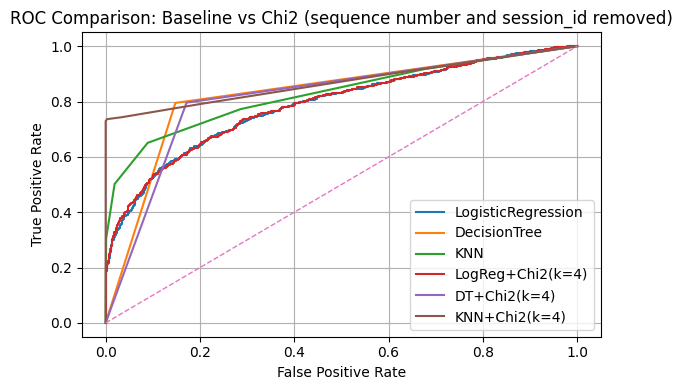

['model_no_seq_id_session_id.joblib']

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import joblib

# Load data
df = pd.read_csv('Cybersecurity Intrusion Detection.csv')

# Remove the first column (assuming it's 'sequence number')
df = df.drop(df.columns[0], axis=1)

# Remove 'session_id' if it exists
if 'session_id' in df.columns:
    df = df.drop('session_id', axis=1)


X = df.drop('attack_detected', axis=1)
y = df['attack_detected']

# Define feature types
# Update categorical and numerical features after dropping columns
categorical = ['protocol_type', 'encryption_used', 'browser_type', 'unusual_time_access']
numerical = [c for c in X.columns if c not in categorical]


# Preprocessors
pre_std = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])
pre_mm = ColumnTransformer([
    ('num', MinMaxScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

# Dense converter function
def to_dense_func(a):
    return a.toarray() if hasattr(a, "toarray") else a

to_dense = FunctionTransformer(to_dense_func, accept_sparse=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Baseline pipelines
log_pipe = Pipeline([('pre', pre_std), ('dense', to_dense), ('clf', LogisticRegression(max_iter=1000))])
dt_pipe  = Pipeline([('pre', pre_std), ('dense', to_dense), ('clf', DecisionTreeClassifier(random_state=42))])
knn_pipe = Pipeline([('pre', pre_std), ('dense', to_dense), ('clf', KNeighborsClassifier(n_neighbors=5))])

# Chi2 selector + pipelines
k_chi2 = 4
chi2_sel = SelectKBest(chi2, k=k_chi2)
log_chi2 = Pipeline([('pre', pre_mm), ('dense', to_dense), ('chi2', chi2_sel),
                     ('clf', LogisticRegression(max_iter=1000))])
dt_chi2  = Pipeline([('pre', pre_mm), ('dense', to_dense), ('chi2', chi2_sel),
                     ('clf', DecisionTreeClassifier(random_state=42))])
knn_chi2 = Pipeline([('pre', pre_mm), ('dense', to_dense), ('chi2', chi2_sel),
                     ('clf', KNeighborsClassifier(n_neighbors=5))])

# Fit all models
for pipe in [log_pipe, dt_pipe, knn_pipe, log_chi2, dt_chi2, knn_chi2]:
    pipe.fit(X_train, y_train)

# Evaluate
models = {
    "LogisticRegression": log_pipe,
    "DecisionTree":      dt_pipe,
    "KNN":               knn_pipe,
    f"LogReg+Chi2(k={k_chi2})": log_chi2,
    f"DT+Chi2(k={k_chi2})":     dt_chi2,
    f"KNN+Chi2(k={k_chi2})":    knn_chi2
}

def print_metrics(name, y_true, y_pred, y_prob):
    print(f"--- {name} ---")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC  : {roc_auc_score(y_true, y_prob):.4f}\n")

for name, pipe in models.items():
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1]
    print_metrics(name, y_test, y_pred, y_prob)

# ROC plot
plt.figure(figsize=(6,4))
for name, pipe in models.items():
    fpr, tpr, _ = roc_curve(y_test, pipe.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparison: Baseline vs Chi2 (sequence number and session_id removed)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig('roc_curve_no_seq_id_session_id.png') # Save as PNG
plt.savefig('roc_curve_no_seq_id_session_id.jpg') # Save as JPG

plt.show()

model_filename = 'model_no_seq_id_session_id.joblib'
joblib.dump(log_pipe, model_filename)

In [ ]:
## Which algorithms' performance are increased and why?

Based on the results after applying Chi2 feature selection, here's a summary of which algorithms' performance increased and why:

* Logistic Regression: Showed a slight improvement in most metrics (accuracy, precision, F1 score, and AUC-ROC). This is likely because removing less relevant features helped the model find a better decision boundary by reducing noise and focusing on the most informative features.
* Decision Tree: Most metrics decreased slightly. Decision trees are less sensitive to irrelevant features, so removing them didn't provide a significant benefit and might have even removed some slightly useful information.
* KNN: Had a notable increase in performance, especially in precision. This suggests that the features selected by Chi2 are particularly good at separating the classes, which is beneficial for KNN as it relies on distances between data points. Removing irrelevant features reduces the noise in the distance calculations.
                                                                        In general, for models like Logistic Regression and KNN that are more sensitive to feature scaling and irrelevant features, feature selection methods like Chi2 can improve performance by providing a cleaner, more relevant set of features to learn from.

In [ ]:
# what are differences between linear regression and logestic regression?

In [ ]:
linear regression predicts continuous values, while logistic regression predicts categorical outcomes (often binary probabilities)

In [ ]:
## You save the three models and upload them with the code on GitHub

In [ ]:
## can you save the AUC-ROC as png, jpg formate for your report?

In [ ]:
# Try to remove the first column from the dataset (sequence number) and see how this one affect the performance?